Note: This code was copied from [mne.tools](https://mne.tools) and extended to include source analysis using an LSTM network.

# Optically pumped magnetometer (OPM) data

In this dataset, electrical median nerve stimulation was delivered to the
left wrist of the subject. Somatosensory evoked fields were measured using
nine QuSpin SERF OPMs placed over the right-hand side somatomotor area. Here
we demonstrate how to localize these custom OPM data in MNE.


In [1]:
import os.path as op

import numpy as np
import mne
# !pip install esinet
%matplotlib inline

data_path = mne.datasets.opm.data_path()
subject = 'OPM_sample'
subjects_dir = op.join(data_path, 'subjects')
raw_fname = op.join(data_path, 'MEG', 'OPM', 'OPM_SEF_raw.fif')
bem_fname = op.join(subjects_dir, subject, 'bem',
                    subject + '-5120-5120-5120-bem-sol.fif')
fwd_fname = op.join(data_path, 'MEG', 'OPM', 'OPM_sample-fwd.fif')
coil_def_fname = op.join(data_path, 'MEG', 'OPM', 'coil_def.dat')

Using default location ~/mne_data for opm...


100%|██████████| Downloading : 1.17G/1.17G [01:46<00:00,    11.8MB/s]

Verifying hash 370ad1dcfd5c47e029e692c85358a374.


Decompressing the archive: C:\Users\Lukas\mne_data\MNE-OPM-data.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['C:\\Users\\Lukas\\mne_data\\MNE-OPM-data']


## Prepare data for localization
First we filter and epoch the data:



Opening raw data file C:\Users\Lukas\mne_data\MNE-OPM-data\MEG\OPM\OPM_SEF_raw.fif...
Isotrak not found
    Range : 0 ... 700999 =      0.000 ...   700.999 secs
Ready.
Reading 0 ... 700999  =      0.000 ...   700.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 331 samples (0.331 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.00
- Lower transition

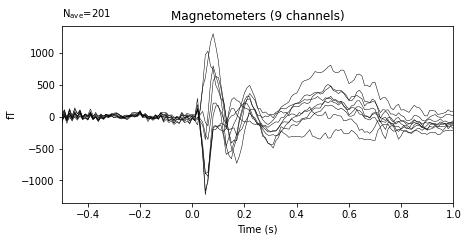

Computing rank from data with rank=None
    Using tolerance 2.1e-10 (2.2e-16 eps * 9 dim * 1.1e+05  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 10251
[done]


In [2]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(None, 90, h_trans_bandwidth=10.)
raw.notch_filter(50., notch_widths=1)


# Set epoch rejection threshold a bit larger than for SQUIDs
reject = dict(mag=2e-10)
tmin, tmax = -0.5, 1

# Find median nerve stimulator trigger
event_id = dict(Median=257)
events = mne.find_events(raw, stim_channel='STI101', mask=257, mask_type='and')
picks = mne.pick_types(raw.info, meg=True, eeg=False)
# We use verbose='error' to suppress warning about decimation causing aliasing,
# ideally we would low-pass and then decimate instead
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, verbose='error',
                    reject=reject, picks=picks, proj=False, decim=10,
                    preload=True)
evoked = epochs.average()
evoked.plot()
cov = mne.compute_covariance(epochs, tmax=0.)
# del epochs, raw

Examine our coordinate alignment for source localization and compute a
forward operator:

<div class="alert alert-info"><h4>Note</h4><p>The Head<->MRI transform is an identity matrix, as the
          co-registration method used equates the two coordinate
          systems. This mis-defines the head coordinate system
          (which should be based on the LPA, Nasion, and RPA)
          but should be fine for these analyses.</p></div>



In [3]:
bem = mne.read_bem_solution(bem_fname)
trans = mne.transforms.Transform('head', 'mri')  # identity transformation

src = mne.setup_source_space(subject, spacing='ico3', surface='white',
                                        subjects_dir=subjects_dir, add_dist=False,
                                        n_jobs=-1, verbose=0)
# To compute the forward solution, we must
# provide our temporary/custom coil definitions, which can be done as::
#
with mne.use_coil_def(coil_def_fname):
    fwd = mne.make_forward_solution(
        raw.info, trans, src, bem, eeg=False, mindist=5.0,
        n_jobs=1, verbose=True)

# fwd = mne.read_forward_solution(fwd_fname)
# use fixed orientation here just to save memory later
mne.convert_forward_solution(fwd, force_fixed=True, copy=False)

with mne.use_coil_def(coil_def_fname):
    fig = mne.viz.plot_alignment(evoked.info, trans=trans, subject=subject,
                                 subjects_dir=subjects_dir,
                                 surfaces=('head', 'pial'), bem=bem)

mne.viz.set_3d_view(figure=fig, azimuth=45, elevation=60, distance=0.4,
                    focalpoint=(0.02, 0, 0.04))

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear_collocation BEM solution from C:\Users\Lukas\mne_data\MNE-OPM-data\subjects\OPM_sample\bem\OPM_sample-5120-5120-5120-bem-sol.fif
Source space          : <SourceSpaces: [<surface (lh), n_vertices=169022, n_used=642>, <surface (rh), n_vertices=169992, n_used=642>] MRI (surface RAS) coords, subject 'OPM_sample', ~24.6 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 1284 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00

Read   9 MEG channels from info
2 coil definitio

## Perform dipole fitting



BEM               : <ConductorModel | BEM (3 layers)>
MRI transform     : instance of Transform
Head origin       :    1.3  -15.5   36.7 mm rad =   77.9 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using standard MEG coil definitions.

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     0.999800  0.015800 -0.009200       0.10 mm
    -0.018100  0.930500 -0.365900      16.60 mm
     0.002800  0.366000  0.930600     -14.40 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read   9 MEG channels from info
2 coil definitions read
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.999800  0.015800 -0.009200       0.10 mm
    -0.018100  0.930500 -0.365900      16.

c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\dipole.py:1005: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  C = linalg.pinvh(J, rcond=1e-14)


---- Fitted :    50.0 ms, distance to inner skull : 15.3529 mm


c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\dipole.py:1005: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  C = linalg.pinvh(J, rcond=1e-14)


---- Fitted :    60.0 ms, distance to inner skull : 18.6968 mm


c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\dipole.py:1005: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  C = linalg.pinvh(J, rcond=1e-14)


---- Fitted :    70.0 ms, distance to inner skull : 14.6240 mm


c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\dipole.py:1005: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  C = linalg.pinvh(J, rcond=1e-14)


---- Fitted :    80.0 ms, distance to inner skull : 5.0627 mm
5 time points fitted


c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\dipole.py:1005: DeprecationWarning: Use of the "cond" and "rcond" keywords are deprecated and will be removed in future versions of SciPy. Use "atol" and "rtol" keywords instead
  C = linalg.pinvh(J, rcond=1e-14)


Best dipole at t=50.0 ms with 99.7% GOF


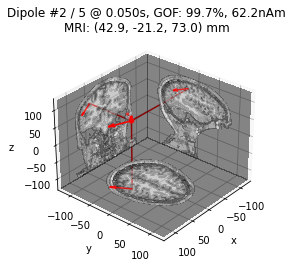

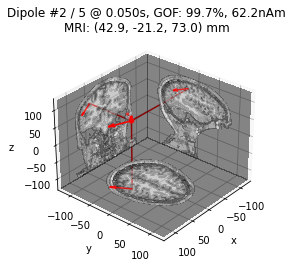

In [5]:
# Fit dipoles on a subset of time points
with mne.use_coil_def(coil_def_fname):
    dip_opm, _ = mne.fit_dipole(evoked.copy().crop(0.040, 0.080),
                                cov, bem, trans, verbose=True)
idx = np.argmax(dip_opm.gof)
print('Best dipole at t=%0.1f ms with %0.1f%% GOF'
      % (1000 * dip_opm.times[idx], dip_opm.gof[idx]))

# Plot N20m dipole as an example
dip_opm.plot_locations(trans, subject, subjects_dir,
                       mode='orthoview', idx=idx)

## Perform minimum-norm localization
Due to the small number of sensors, there will be some leakage of activity
to areas with low/no sensitivity. Constraining the source space to
areas we are sensitive to might be a good idea.



In [6]:
inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked.info, fwd, cov, loose=0., depth=None)

method = "MNE"
snr = 3.
lambda2 = 1. / snr ** 2
initial_time = evoked.times[np.argmax(evoked._data.std(axis=0))]
stc = mne.minimum_norm.apply_inverse(
    evoked, inverse_operator, lambda2, method=method,
    pick_ori=None, verbose=True)

# Plot source estimate at time of best dipole fit
brain = stc.plot(hemi='rh', views='lat', subjects_dir=subjects_dir,
                 initial_time=initial_time,
                 clim=dict(kind='percent', lims=[99, 99.9, 99.99]),
                 size=(400, 300), background='w')

Computing inverse operator with 9 channels.
    9 out of 9 channels remain after picking
Selected 9 channels
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 2.2e-15 (2.2e-16 eps * 9 dim * 1.1  max singular value)
    Estimated rank (mag): 9
    MAG: rank 9 computed from 9 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 1.42092
    scaling factor to adjust the trace = 1.19924e+18 (nchan = 9 nzero = 0)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 201
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 9 (0 small eigenvalues omitted)
Applying inverse operator to "Median"...


---
# Use ANNs

## Simulate and train

Increase the number of simulations and epochs for better results!

In [7]:
import sys; sys.path.insert(0, '../')
from esinet.simulation import Simulation
from esinet.net import Net

mne.set_config('SUBJECTS_DIR', subjects_dir)
model_type = 'LSTM'  # can be 'FC' or 'ConvDip', too

sim = Simulation(fwd, epochs.info).simulate(1000)  # simulate some source & EEG data data
net = Net(fwd, model_type=model_type)  # create neural nework object
net.fit(sim, epochs=10)  # train the neural network with only few epochs

Simulating data based on sparse patches.


100%|██████████| 1000/1000 [00:00<00:00, 10666.83it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 1000/1000 [00:01<00:00, 561.86it/s]


preprocess data
werks3
Model: "Contextualizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 9)]    0           []                               
                                                                                                  
 FC1 (TimeDistributed)          (None, None, 200)    2000        ['Input[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, None, 200)    0           ['FC1[0][0]']                    
                                                                                                  
 LSTM1 (Bidirectional)          (None, None, 64)     44928       ['dropout[0][0]']                
                                                              

## Predict and Visualize

In [11]:
stc_lstm = net.predict(evoked)[0]

# Plot source estimate at time of best dipole fit
brain = stc_lstm.plot(hemi='rh', views='lat', subjects_dir=subjects_dir,
                 initial_time=0,
                 clim=dict(kind='percent', lims=[99, 99.9, 99.99]),
                 size=(400, 300), background='w')

c:\Users\Lukas\Envs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Using control points [7.29826781e-10 2.70501093e-09 5.74703767e-09]
